In [ ]:
%pip install opencv-python matplotlib imageio gdown tensorflow==2.16.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\deept\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [2]:
import os
import tensorflow as tf
import cv2
import gdown
import matplotlib.pyplot as plt
from typing import List
import numpy as np
from tensorflow.keras import backend as K

In [3]:
# Ensure GPU memory growth
physical_device = tf.config.list_physical_devices('GPU')
if physical_device:
    try:
        tf.config.experimental.set_memory_growth(physical_device[0], True)
    except:
        pass

In [4]:
# # Download data
#url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
#output = "data.zip"
#gdown.download(url, output, quiet=False)
#gdown.extractall("data.zip")

In [5]:
# Vocabulary setup
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [6]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get((cv2.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32)/std

In [7]:
print(char_to_num(['v','a','i','b']))
print(num_to_char([22,  1,  9,  2]))

tf.Tensor([22  1  9  2], shape=(4,), dtype=int64)
tf.Tensor([b'v' b'a' b'i' b'b'], shape=(4,), dtype=string)


In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [9]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # print(f'This is the path: {path}')
    # file_name = path.split('\\')[-1].split('.')[0]
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(path))[0]
    
    # Construct video and alignment paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    # Ensure files exist
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")

    # Load video frames and alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [10]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [11]:
# # /kaggle/working/data/alignments/s1/bbaf2n.align
# /kaggle/working/data/s1/bbaf2n.mpg
data = tf.data.Dataset.list_files('data/s1/*.mpg') 
data = data.shuffle(500)
data = data.map(mappable_function) # map the function to the dataset
data = data.padded_batch(2, padded_shapes=([75,None,None,None], [40])) # padding to the frames and alignments[40] if less than then padded it 

# With prefetching, the next batch is prepared asynchronously while the current batch is being used by the model, reducing idle time.
# That reduce input latency 
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split 
train = data.take(450)
test = data.skip(450)


In [12]:
len(train), len(test)

(450, 50)

In [13]:
# Two videos and two alignments
videos, alignments = data.as_numpy_iterator().next()

In [14]:
print(f'This is a video shape : {videos.shape}')

This is a video shape : (2, 75, 46, 140, 1)


In [15]:
len(videos), len(alignments)

(2, 2)

In [16]:
sample = data.as_numpy_iterator().next()


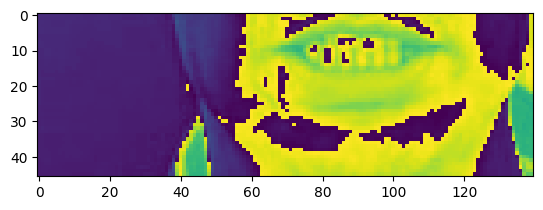

In [17]:
# 0: videos; 0: 1st video out of the batch, 0: return the 40th frame in the video
plt.imshow(sample[0][1][40])
# plt.imshow(videos[0][40]) # both are the same

In [18]:
 test_path = "data/s1/bbaf2n.mpg"

In [19]:
# Testing loading function
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [20]:
print(f'whole the frame: {frames.shape}') # 75 frames, each frame is 46x140x1
frames[0]

whole the frame: (75, 46, 140, 1)


<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991665 ],
        [1.4991665 ],
        [1.4616873 ],
        ...,
        [0.41227078],
        [0.41227078],
        [0.41227078]],

       [[1.4991665 ],
        [1.4991665 ],
        [1.4616873 ],
        ...,
        [0.41227078],
        [0.41227078],
        [0.41227078]],

       [[1.4616873 ],
        [1.4616873 ],
        [1.4991665 ],
        ...,
        [0.33731246],
        [0.33731246],
        [0.33731246]],

       ...,

       [[1.0494165 ],
        [1.0494165 ],
        [1.0119374 ],
        ...,
        [0.11243749],
        [0.11243749],
        [0.07495832]],

       [[1.0494165 ],
        [1.0494165 ],
        [1.0119374 ],
        ...,
        [0.11243749],
        [0.07495832],
        [0.07495832]],

       [[1.0494165 ],
        [1.0494165 ],
        [1.0119374 ],
        ...,
        [0.07495832],
        [0.07495832],
        [0.03747916]]], dtype=float32)>

This is the alingments of the one video: [ 2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23]
 


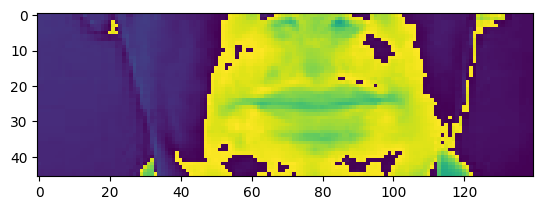

In [21]:
print(f'This is the alingments of the one video: {alignments}')
print(' ')
tf.strings.reduce_join([bytes.decode(i) for i in num_to_char(alignments.numpy()).numpy()])
plt.imshow(frames[74])

In [22]:
# # Lets check above videos we got from data pipelines with alginments
print(tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]]))
print(tf.strings.reduce_join([num_to_char(word) for word in sample[1][1]]))


tf.Tensor(b'place green in d seven again', shape=(), dtype=string)
tf.Tensor(b'bin white in t zero please', shape=(), dtype=string)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, TimeDistributed, Reshape, Bidirectional, LSTM, Dropout, Dense, Activation

In [24]:
print(f'This is a video shape: {data.as_numpy_iterator().next()[0].shape}') #   data.as_numpy_iterator().next()[0][0].shape
print(f'This is a alignment shape: {data.as_numpy_iterator().next()[1].shape}')

This is a video shape: (2, 75, 46, 140, 1)
This is a alignment shape: (2, 40)


In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int64)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int64)
    label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int64)
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
class ProductExampleCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs = None) -> None:
        data = self.dataset.next()
        yhat = model.predict(data[0])
        decode = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join([num_to_char(word) for word in data[1][x]]).numpy().decode('utf-8'))
            print('Predicted: ', tf.strings.reduce_join([num_to_char(word) for word in decode[x]]).numpy().decode('utf-8'))

            print('~'*100)

In [27]:
# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D(pool_size=(1, 2, 2)))

# model.add(TimeDistributed(Reshape((-1,))))

# model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Dense(char_to_num.vocabulary_size()+1,  kernel_initializer='he_normal', activation='softmax'))


model = Sequential()

# First Conv3D block
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

# Second Conv3D block
model.add(Conv3D(256, 3, padding='same'))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

# Third Conv3D block
model.add(Conv3D(75, 3, padding='same'))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

# Flatten the spatial dimensions while preserving the time dimension
model.add(TimeDistributed(Reshape((-1,))))

# First LSTM block
model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Second LSTM block
model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Fully connected output layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


c:\Users\deept\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 46, 140,    │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 23, 70,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 11, 35, 75) │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,473,760 (32.32 MB)

 Trainable params: 8,472,842 (32.32 MB)

 Non-trainable params: 918 (3.59 KB)

In [29]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [30]:
yhat[0].shape

(75, 41)

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'1111111111111c1111111111111111111111111111111111111111111111111111ccccqqqqq'>

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [33]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [34]:
example_callback = ProductExampleCallback(test)

In [35]:
model.compile(loss=CTCLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [36]:
# https://drive.google.com/file/d/1gSbYQ67ihBZw6cc-_ARcSeNcJPW14j0o/view?usp=sharing
# # Replace the ID with the actual file ID from your Google Drive link
# https://drive.google.com/file/d/1Xl2VrkQFWpn2O612qyDinN8L_kyFzv08/view?usp=sharing
# https://drive.google.com/file/d/1oiGL9pDYX4-AdOVuypJEsL9MgXTABjko/view?usp=sharing
#file_id = '1Xl2VrkQFWpn2O612qyDinN8L_kyFzv08'
#gdown.download(f'https://drive.google.com/uc?id={file_id}', 'new_best_weights2.weights.h5', quiet=False)

In [37]:
model.load_weights('new_best_weights2.weights.h5')

c:\Users\deept\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
# model evaulate
test_data = test.as_numpy_iterator()

In [39]:
sample = test_data.next()

In [40]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [41]:
print('='*100)
print('This is original text: ')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

This is original text: 


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at c two pleaseset white by c one soon'>]

In [42]:
decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=True)[0][0].numpy()

In [43]:
print("="* 100)
print('This is prediction: ')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

This is prediction: 


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at c two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white by c one soon'>]

## **Test On Videos**

In [44]:
sample2 = load_data(tf.convert_to_tensor('data/s1/bbaz4n.mpg'))

In [45]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample2[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

In [46]:
yhat = model.predict(tf.expand_dims(sample2[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [48]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

In [49]:
# Resume training from epoch 75
#model.fit(
  #  train,
    #validation_data=test,
   # epochs=150,
    #initial_epoch=100,  # Start from epoch 75
   # callbacks=[checkpoint_callback, reduce_lr, early_stopping, example_callback]
)


SyntaxError: unmatched ')' (1368077554.py, line 8)

In [ ]:
# Train the model
#model.fit(
 #   train,
  #  validation_data=test,
   # epochs=100,
    #callbacks=[checkpoint_callback, reduce_lr, early_stopping, example_callback]
#)